When quantile normalize, ensure measurements fit a specific distribution. Good when specific distribution doesn't matter but relative changes of values within a populationa are important.

3 steps:

1. Sort values along each column.

2. Find the average of each resulting row.

3. Replace each column quantile with the quantile of the average column.

In [1]:
import numpy as np
from scipy import stats

In [2]:
def quantile_norm(X):
    # compute the quantiles
    quantiles = np.mean(np.sort(X, axis=0), axis=1)
    
    # Compute the column-wise ranks. Each observation is replaced with its rank in that column:
    # the smallest observation is replaced by 1, the second-smallest by 2, ..., and the largest by M,
    # the number of rows.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)
    
    # Convert ranks to integer indices from 0 to M-1
    rank_indices = ranks.astype(int) - 1
    
    # Index the quantiles for each rank with the ranks matrix.
    Xn = quantiles[rank_indices]
    
    return Xn

def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

In [3]:
import numpy as np
import pandas as pd

In [5]:
# Import TCGA melanoma data
filename = 'data/counts.txt'
data_table = pd.read_csv(filename, index_col=0)

# columns are samples, rows are genes
print(data_table.iloc[:5, :5])

       00624286-41dd-476f-a63b-d2a5f484bb45  TCGA-FS-A1Z0  TCGA-D9-A3Z1  \
A1BG                                1272.36        452.96        288.06   
A1CF                                   0.00          0.00          0.00   
A2BP1                                  0.00          0.00          0.00   
A2LD1                                164.38        552.43        201.83   
A2ML1                                 27.00          0.00          0.00   

       02c76d24-f1d2-4029-95b4-8be3bda8fdbe  TCGA-EB-A51B  
A1BG                                 400.11        420.46  
A1CF                                   1.00          0.00  
A2BP1                                  0.00          1.00  
A2LD1                                165.12         95.75  
A2ML1                                  0.00          8.00  


In [6]:
# put counts into numpy array
counts = data_table.values

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

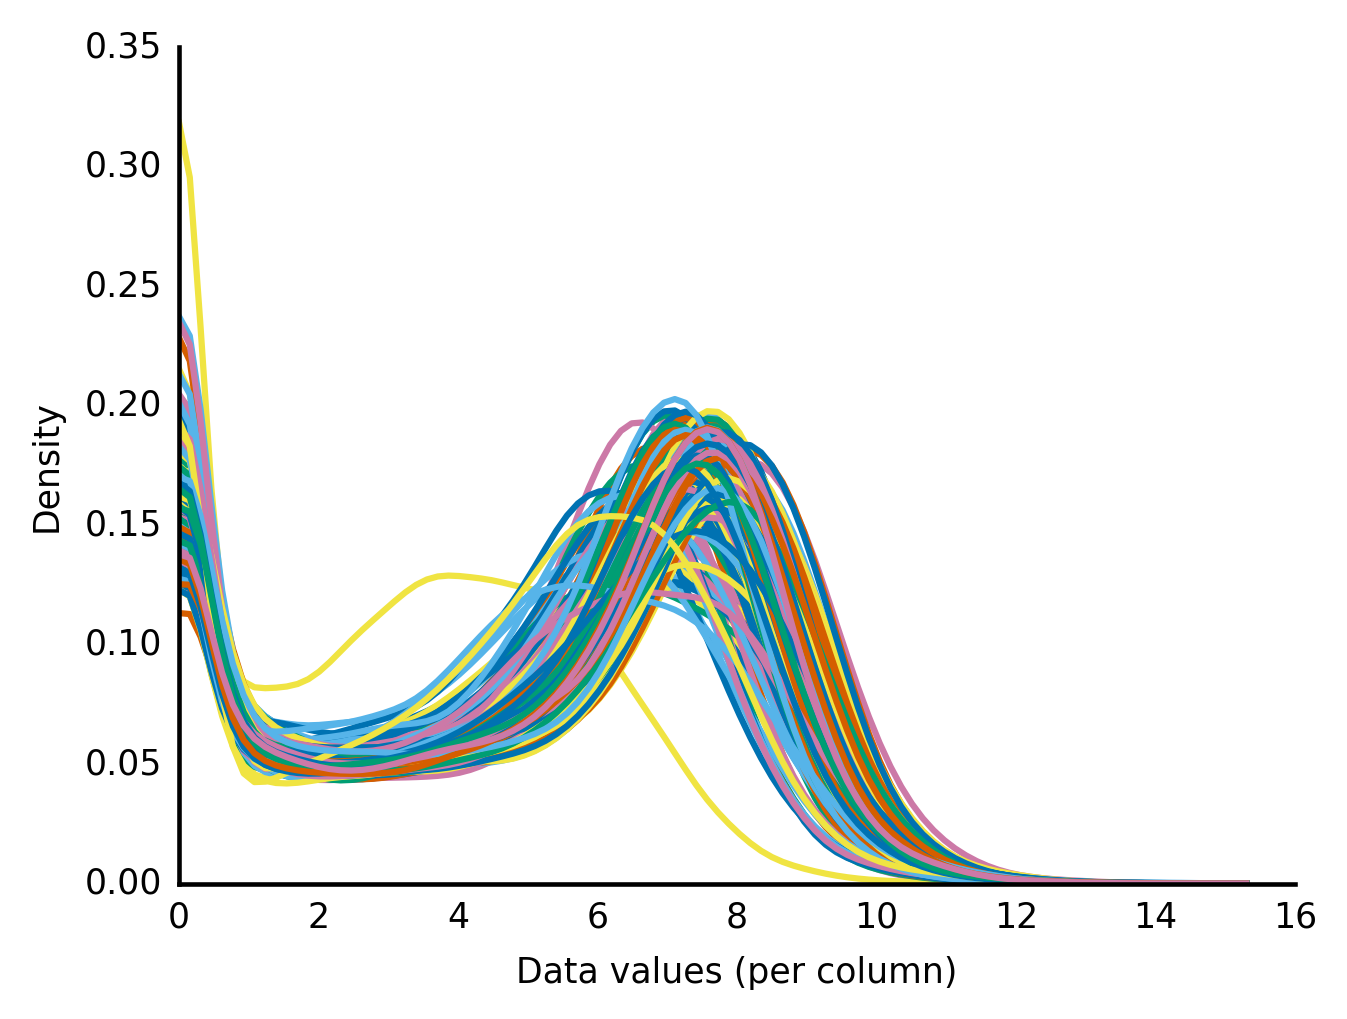

In [9]:
def plot_col_density(data):
    # use gaussian smoothing to estimate the density
    density_per_col = [stats.gaussian_kde(col) for col in data.T]
    x = np.linspace(np.min(data), np.max(data), 100)
    
    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x))
    ax.set_xlabel('Data values (per column)')
    ax.set_ylabel('Density')
    
# Plot the distributions before normalizing:
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

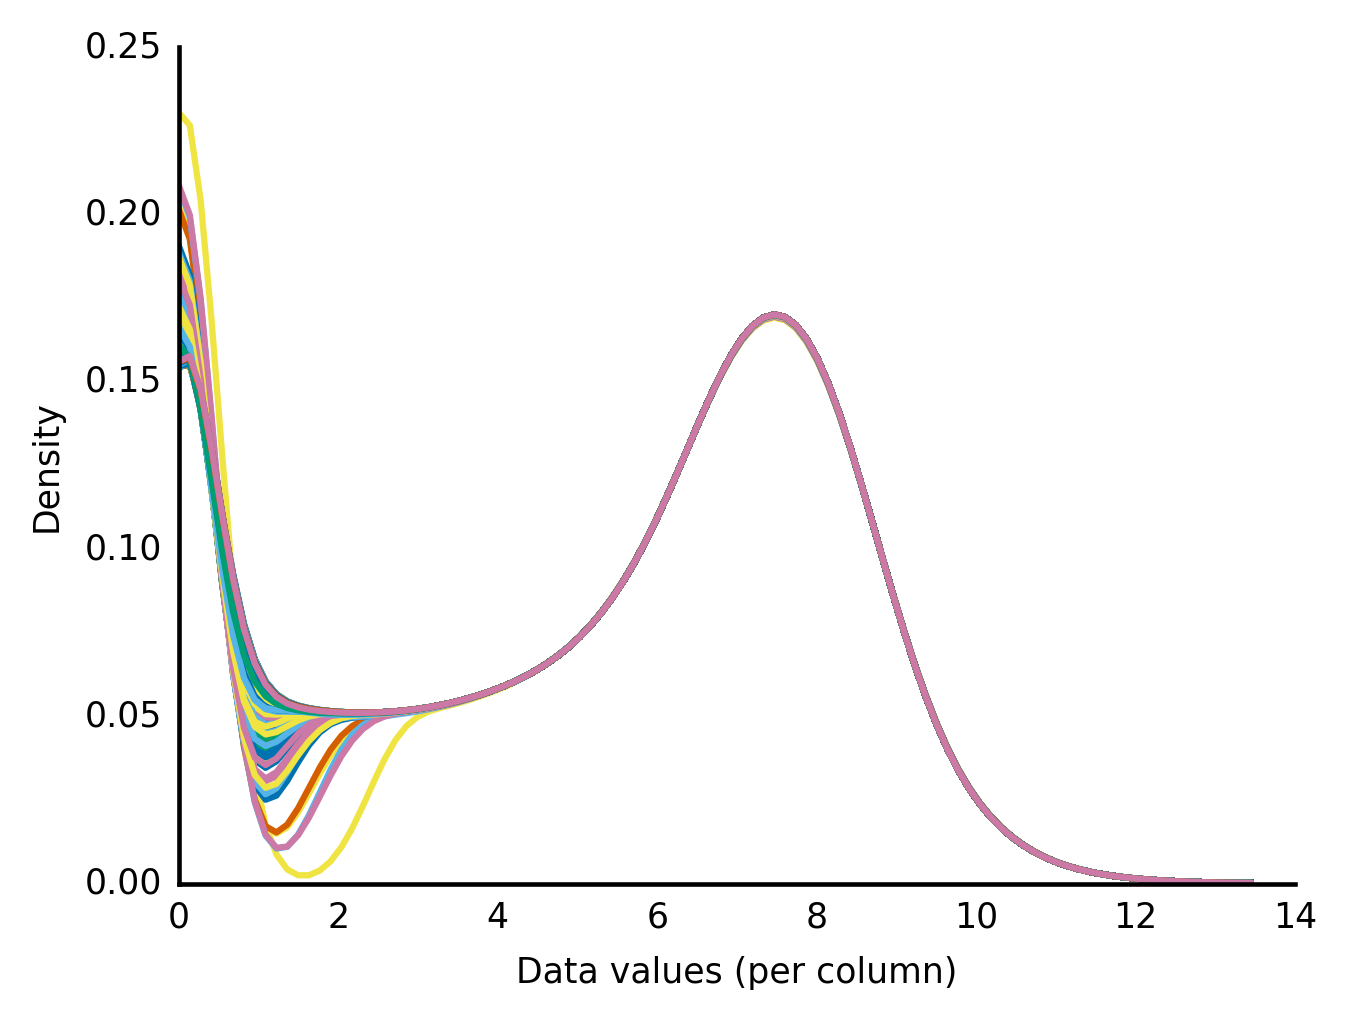

In [10]:
# Normalize these distributions with quantile normalization!
log_counts_normalized = quantile_norm_log(counts)
plot_col_density(log_counts_normalized)

In [15]:
def most_variable_rows(data, *, n=1500):
    # compute variance along the columns axis
    rowvar = np.var(data, axis=1)
    # get sorted indices, taking the last n
    sorted_indices = np.argsort(rowvar)[-n:]
    # use as index for data
    variable_data = data[sorted_indices, :]
    
    return variable_data

In [16]:
from scipy.cluster.hierarchy import linkage

def bicluster(data, linkage_method='average', distance_metric='correlation'):
    y_rows = linkage(data, method=linkage_method, metric=distance_metric)
    y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
    return y_rows, y_cols

In [23]:
from scipy.cluster.hierarchy import dendrogram, leaves_list

def clear_spines(axes):
    for loc in ['left', 'right', 'top', 'bottom']:
        axes.spines[loc].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    
def plot_bicluster(data, row_linkage, col_linkage, row_nclusters=10, col_nclusters=3):
    fig = plt.figure(figsize=(4.8, 4.8))
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
    threshold_r = (row_linkage[-row_nclusters, 2] + row_linkage[-row_nclusters+1, 2]) /2
    with plt.rc_context({'lines.linewidth':0.75}):
        dendrogram(row_linkage, orientation='left', color_threshold=threshold_r, ax=ax1)
    clear_spines(ax1)
    
    ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
    threshold_c = (col_linkage[-col_nclusters, 2] + col_linkage[-col_nclusters+1, 2]) / 2
    with plt.rc_context({'lines.linewidth':0.75}):
        dendrogram(col_linkage, color_threshold=threshold_c, ax=ax2)
    clear_spines(ax2)
    
    ax = fig.add_axes([0.3, 0.1, 0.6, 0.6])
    
    idx_rows = leaves_list(row_linkage)
    data = data[idx_rows, :]
    idx_cols = leaves_list(col_linkage)
    data = data[:, idx_cols]
    
    im = ax.imshow(data, aspect='auto', origin='lower', cmap='YlGnBu_r')
    clear_spines(ax)
    
    ax.set_xlabel('Samples')
    ax.set_ylabel('Genes', labelpad=125)
    
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
    plt.colorbar(im, cax=axcolor)
    
    plt.show()
    
    

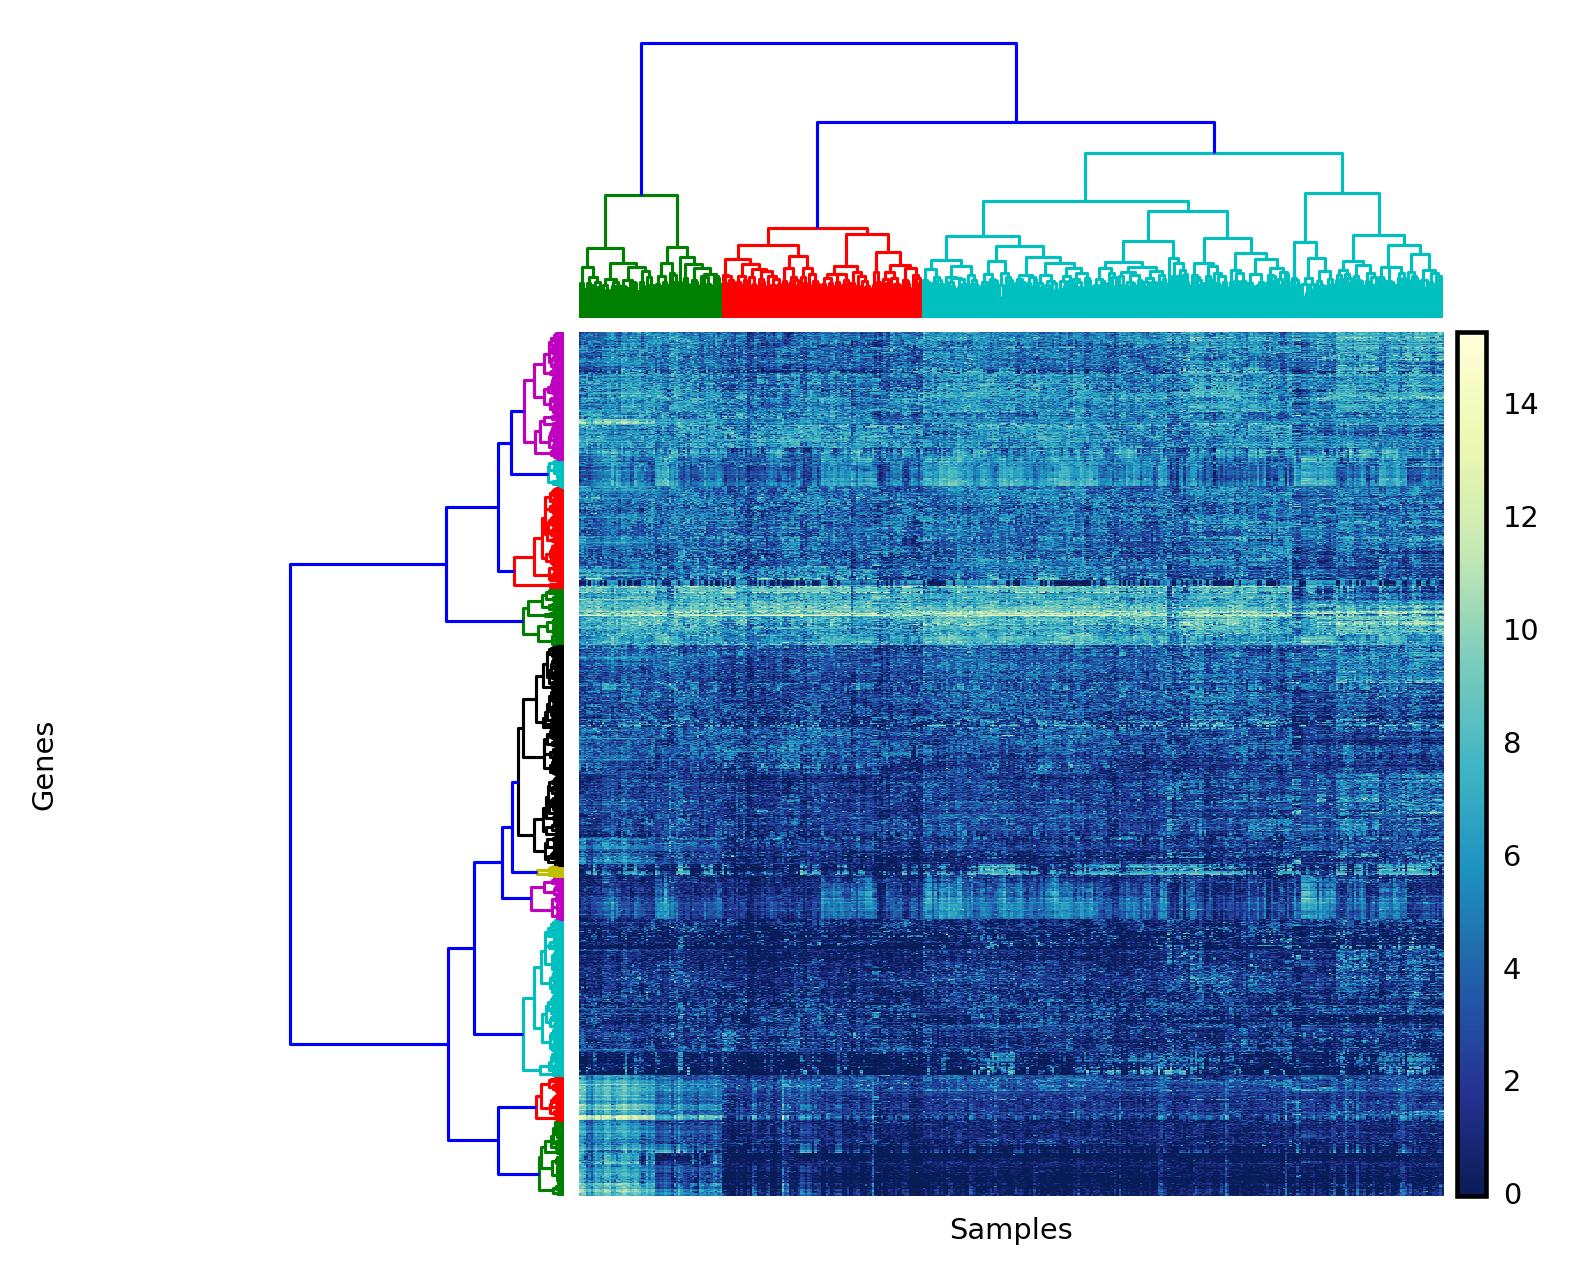

In [24]:
counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(counts_var, linkage_method='ward', distance_metric='euclidean')
with plt.style.context('style/thinner.mplstyle'):
    plot_bicluster(counts_var, yr, yc)